In [18]:
import os
import pathlib
from collections import defaultdict

from tqdm import tqdm
import pandas as pd
import seaborn as sns
import tensorboard

from webeyetrack.constants import GIT_ROOT

CWD = pathlib.Path("").parent 
EXP_OUTPUTS_DIR = CWD / 'exp_outputs'
EYE_OF_THE_TYPER_EXP_DIR = EXP_OUTPUTS_DIR / 'eye_of_the_typer' / '20250608221054-EyeOfTheTyper-test_affine_with_adam_n10_l-4'
EMBEDDING_SIZE_EXP_DIR = EXP_OUTPUTS_DIR / 'embedding_size'
os.makedirs(EXP_OUTPUTS_DIR, exist_ok=True)

OUTPUT_DIR = EXP_OUTPUTS_DIR / 'plots'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Generate the demographics plots using the Eye of the Typer demographics data
demographics_df = pd.read_csv(GIT_ROOT / 'data' / 'participant_characteristics.csv')
demographics_df.head(10)

,Participant ID,Participant Log ID,Date,Setting,Display Width (pixels),Display Height (pixels),Screen Width (cm),Screen Height (cm),Distance From Screen (cm),Screen Recording Start Time (Unix milliseconds),...,Self-Reported Eye Color,Facial Hair,Self-Reported Vision,Touch Typer,Self-Reported Handedness,Weather,Pointing Device,Notes,Time of day,Duration
0,P_01,1491423217564,4/5/2017,Laptop,1440,900,33.17,20.73,60.0,1.491424e+12,...,Dark Brown to Brown,NaN,Normal,Yes,Right,Cloudy,Trackpad,Did not see the button at the bottom of the Go...,16:00,16:40:00
1,P_02,1491487691210,4/6/2017,Laptop,1440,900,33.17,20.73,55.0,1.491488e+12,...,Dark Brown to Brown,NaN,Normal,No,Right,Indoors,Trackpad,NaN,10:00,22:43:00
2,P_07,1491577862552,4/7/2017,Laptop,1440,900,33.17,20.73,NaN,1.491580e+12,...,Dark Brown to Brown,NaN,Glasses,No,Right,Sunny,Trackpad,No video for the thankyou page,11:00,20:38:00
3,P_14,1491927757191,4/11/2017,Laptop,1440,900,33.17,20.73,65.0,1.491928e+12,...,Dark Brown to Brown,Beard,Normal,Yes,Right,Sunny,Mouse,NaN,12:00,18:22:00
4,P_15,1491933738937,4/11/2017,Laptop,1440,900,33.17,20.73,NaN,1.491934e+12,...,Dark Brown to Brown,NaN,Normal,No,Right,Sunny,Trackpad,No video for the thankyou page,14:00,14:56:00
5,P_24,1492106295971,4/13/2017,Laptop,1440,900,33.17,20.73,63.0,1.492107e+12,...,Dark Brown to Brown,NaN,Contacts,No,Left,Sunny,Mouse,NaN,14:00,18:54:00
6,P_28,1492182876610,4/14/2017,Laptop,1440,900,33.17,20.73,52.0,1.492183e+12,...,Dark Brown to Brown,NaN,Contacts,No,Right,Indoors,Trackpad,No video for the thankyou page. Went to Google...,11:00,19:26:00
7,P_29,1492189262993,4/14/2017,Laptop,1440,900,33.17,20.73,54.0,1.492190e+12,...,Dark Brown to Brown,Beard,Glasses,No,Right,Indoors,Trackpad,No video for the thankyou page,13:00,16:05:00
8,P_33,1492456607850,4/17/2017,Laptop,1440,900,33.17,20.73,69.0,1.492457e+12,...,Dark Brown to Brown,NaN,Normal,Yes,Right,Cloudy,Trackpad,No video for the thankyou page. No Tobii gaze ...,15:00,17:00:00
9,P_34,1492521777728,4/18/2017,Laptop,1440,900,33.17,20.73,51.0,NaN,...,Dark Brown to Brown,NaN,Normal,No,Right,Sunny,Trackpad,No screen recording,9:00,24:29:00


In [8]:
total_data = defaultdict(list)
for par_dir in (EYE_OF_THE_TYPER_EXP_DIR / 'per_participant').iterdir():
    for section_dir in par_dir.iterdir():
        data_file = f"{par_dir.stem}_metrics.csv"
        data = pd.read_csv(section_dir / data_file)

        total_data['participant'].append(par_dir.stem)
        total_data['section'].append(section_dir.stem)
        
        for col in data.columns:
            if col not in ['participant']:
                total_data[col].append(data[col].iloc[0])

total_df = pd.DataFrame(total_data)
total_df.head(10)

,participant,section,webGazerAvgL1,webEyeTrackAvgL1
0,P_01,study-dot_test,3.897109,3.299243
1,P_01,study-dot_test_final,9.562728,4.506078
2,P_02,study-dot_test,8.795707,4.837185
3,P_02,study-dot_test_final,11.736777,6.392345
4,P_06,study-dot_test,6.347425,5.856389
5,P_06,study-dot_test_final,16.169585,7.822558
6,P_07,study-dot_test,5.820472,8.121677
7,P_07,study-dot_test_final,12.477518,7.966867
8,P_08,study-dot_test,7.304759,15.231219
9,P_08,study-dot_test_final,17.157171,17.861156


In [41]:
# Load the raw data over the sections and stitch them together
ALL_SECTIONS_DIR = EXP_OUTPUTS_DIR / 'eye_of_the_typer' / '20250610170545-EyeOfTheTyper-all_sections_restart'
SECTIONS = [
    'study-dot_test.webm_gazePredictionsDone',
    'study-benefits_of_running_writing.webm_gazePredictionsDone',
    'study-educational_advantages_of_social_networking_sites_writing.webm_gazePredictionsDone',
    'study-where_to_find_morel_mushrooms_writing.webm_gazePredictionsDone',
    'study-tooth_abscess_writing.webm_gazePredictionsDone',
    'study-dot_test_final.webm_gazePredictionsDone'
]

columns_to_keep = [
    'frameTimeEpoch',
    'frameNum',
    'tobiiGazeX',
    'tobiiGazeY',
    'webGazerX',
    'webGazerY',
    'webEyeTrackX',
    'webEyeTrackY',
]

all_dfs = {}
for dir in tqdm((ALL_SECTIONS_DIR / 'per_participant').iterdir(), total=len(list((ALL_SECTIONS_DIR / 'per_participant').iterdir()))):
    # Obtain the configurations for the participant
    par_config = demographics_df[demographics_df['Participant ID'] == dir.stem]
    screen_width_cm = par_config['Screen Width (cm)'].values[0]
    screen_height_cm = par_config['Screen Height (cm)'].values[0]

    par_dfs = {}
    if dir.is_dir():
        for section_dir in dir.iterdir():
            data_file = f"raw_data.csv"
            data = pd.read_csv(section_dir / data_file)
            data = data[columns_to_keep]
            for col in ['tobiiGazeX', 'webGazerX', 'webEyeTrackX']:
                if col in data.columns:
                    data[col] = (data[col] + 0.5) * screen_width_cm
            for col in ['tobiiGazeY', 'webGazerY', 'webEyeTrackY']:
                if col in data.columns:
                    data[col] = (data[col] + 0.5) * screen_height_cm
            par_dfs[section_dir.name] = data

    # Combine all sections based on the SECTIONS order
    combined_df = pd.concat([par_dfs[section] for section in SECTIONS if section in par_dfs], ignore_index=True)

    # Sort by 'frameTimeEpoch'
    combined_df.sort_values(by='frameTimeEpoch', inplace=True)
    combined_df.reset_index(drop=True, inplace=True)

    # Change 'frameTimeEpoch' from milliseconds to seconds, reset by the first frame
    combined_df['frameTimeEpoch'] = (combined_df['frameTimeEpoch'] - combined_df['frameTimeEpoch'].iloc[0]) / 1000.0
    all_dfs[dir.stem] = combined_df

 43%|████▎     | 22/51 [00:01<00:02, 12.85it/s]/tmp/ipykernel_556073/3342883091.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([par_dfs[section] for section in SECTIONS if section in par_dfs], ignore_index=True)
 78%|███████▊  | 40/51 [00:03<00:00, 13.64it/s]/tmp/ipykernel_556073/3342883091.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([par_dfs[section] for section in SECTIONS if section in par_dfs], ignore_index=True)
100%|██████████|

      frameTimeEpoch  frameNum  tobiiGazeX  tobiiGazeY  webGazerX  webGazerY  \
0              0.000         1   12.448078    8.669332        NaN        NaN   
723          283.497         1    4.010913    5.945950  42.716363  10.043807   
1068         300.026       495    6.809155    7.114818   1.474325   9.398623   
1949         350.066      1995   15.231621    8.360152  11.996755   7.844935   
2733         469.484         0    9.421646    6.147279        NaN        NaN   
3214         500.026       913   10.926625    7.638881  10.509005   6.795562   
3807         550.009      2411   21.610380    6.729947  14.225845   5.908365   
4398         600.019      3910    5.088943    7.945917   9.886548   6.900731   
4743         650.114      5411   16.966874    9.352625  15.190242   6.853450   
5387         700.029      6907    8.907695    3.321444   6.861717   3.459863   
5868         752.647         1   28.675361   10.229363  20.353840  12.278190   
6154         854.505         8   19.0708

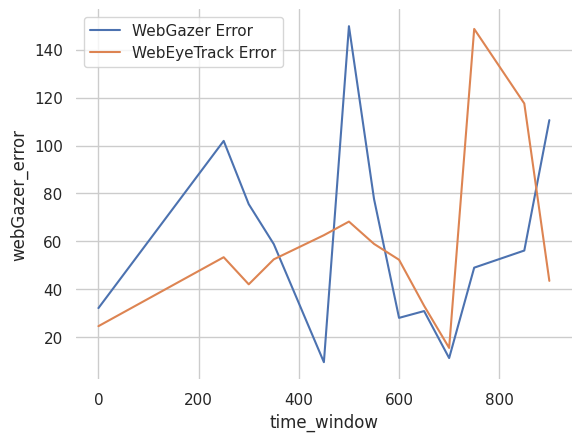

In [48]:
# For testing, plot a single participant's data into a line plot illustrating the error between (WebGazer-Tobii) and (WebEyeTrack-Tobii)
df = all_dfs['P_01']
df_copy = df.copy()
df_copy.head(10)
# print(df_copy['frameTimeEpoch'].min(), df_copy['frameTimeEpoch'].max())
# print(len(df_copy))

# Split the data into time windows of 10 seconds, compute the mean error, also compute the runnign mean error
time_window = 50.0
df_copy['time_window'] = (df_copy['frameTimeEpoch'] // time_window) * time_window
df_copy['webGazer_error'] = (df_copy['webGazerX'] - df_copy['tobiiGazeX']) ** 2 + (df_copy['webGazerY'] - df_copy['tobiiGazeY']) ** 2
df_copy['webEyeTrack_error'] = (df_copy['webEyeTrackX'] - df_copy['tobiiGazeX']) ** 2 + (df_copy['webEyeTrackY'] - df_copy['tobiiGazeY']) ** 2
df_copy['webGazer_error'] = df_copy.groupby('time_window')['webGazer_error'].transform('mean')
df_copy['webEyeTrack_error'] = df_copy.groupby('time_window')['webEyeTrack_error'].transform('mean')
df_copy = df_copy.drop_duplicates(subset=['time_window'])
print(df_copy.head(100))

sns.set_theme(style="whitegrid")
sns.lineplot(data=df_copy, x='time_window', y='webGazer_error', label='WebGazer Error')
sns.lineplot(data=df_copy, x='time_window', y='webEyeTrack_error', label='WebEyeTrack Error')
sns.despine(left=True, bottom=True)

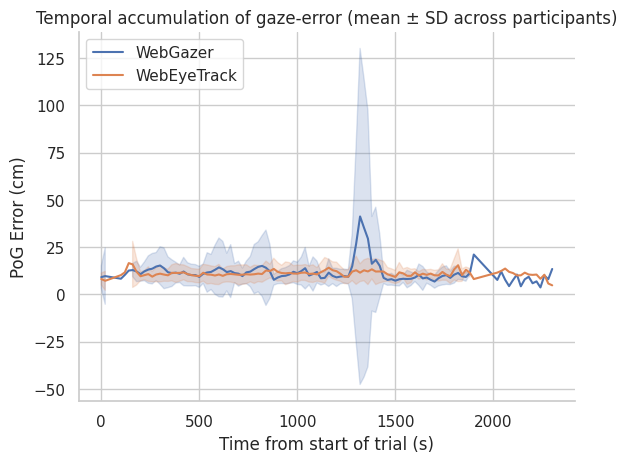

In [66]:
# --- parameters ------------------------------------------------------------
TIME_WINDOW = 20.0        # seconds (use whatever makes sense for you)
ESTIMATOR  = "mean"       # could be "median" or a callable
ERRORBAR   = "sd"         # or "ci" | "pi" | "se" | None   (Seaborn ≥ 0.13)

# ----------------------------- collect per-participant summaries --------------
records = []                                  # collect per-participant summaries
for pid, df in all_dfs.items():               # all_dfs = {"P_01": df1, "P_02": df2, …}
    d = df.copy()

    # 1) put everyone on a common clock: 0 s = first sample in that trial
    d["t_rel"] = d["frameTimeEpoch"] - d["frameTimeEpoch"].iloc[0]

    # 2) drop into fixed-width bins
    d["time_window"] = (d["t_rel"] // TIME_WINDOW) * TIME_WINDOW

    # 3) compute per-sample squared Euclidean error for each method
    # d["webGazer_error"]   = (d["webGazerX"]   - d["tobiiGazeX"])**2 + (d["webGazerY"]   - d["tobiiGazeY"])**2
    # d["webEyeTrack_error"] = (d["webEyeTrackX"] - d["tobiiGazeX"])**2 + (d["webEyeTrackY"] - d["tobiiGazeY"])**2
    # 3) Compute per-sample L1 error for each method
    d["WebGazer"] = ((d["webGazerX"] - d["tobiiGazeX"])**2 + (d["webGazerY"] - d["tobiiGazeY"])**2)**0.5
    d["WebEyeTrack"] = ((d["webEyeTrackX"] - d["tobiiGazeX"])**2 + (d["webEyeTrackY"] - d["tobiiGazeY"])**2)**0.5

    # 4) summarise within each bin (mean here; could be median, sum, etc.)
    d = (
        d.groupby("time_window", as_index=False)
          .agg(WebGazer=("WebGazer",  "mean"),
               WebEyeTrack=("WebEyeTrack", "mean"))
    )
    d["participant"] = pid                       # keep ID so we know who is who
    records.append(d)

# ---------------------------------------------------------------------------
# long-format = easiest for seaborn
long = (
    pd.concat(records, ignore_index=True)
      .melt(id_vars=["participant", "time_window"],
            value_vars=["WebGazer", "WebEyeTrack"],
            var_name="method", value_name="error")
)

# ---------------------------------------------------------------------------
sns.set_theme(style="whitegrid")
ax = sns.lineplot(
        data=long,
        x="time_window",
        y="error",
        hue="method",
        estimator=ESTIMATOR,         # default = mean
        errorbar=ERRORBAR            # shaded band
      )
ax.set(
    xlabel="Time from start of trial (s)",
    ylabel="PoG Error (cm)",    # or whatever unit you prefer
    title="Temporal accumulation of gaze-error (mean ± SD across participants)"
)

# Make the y-axis logarithmic for better visibility
# ax.set_yscale('log')
# ax.set_ylim(0, 5_000) 
ax.legend(title=False, loc='upper left')
sns.despine()
# plt.show()

# Save the plot
plot_path = OUTPUT_DIR / 'eye_of_the_typer_pog_error_over_time.png'
# sns.lineplot(data=long, x='time_window', y='error', hue='method', estimator=ESTIMATOR, errorbar=ERRORBAR)
ax.get_figure().savefig(plot_path, bbox_inches='tight', dpi=400)


In [15]:
# Generate the accuracy plots via boxplots
accuracy_df = total_df.copy()

# Rename 'webGazerAvgL1' and 'webEyeTrack' to 'WebGazer' and 'WebEyeTrack' respectively
accuracy_df.rename(columns={
    'webGazerAvgL1': 'WebGazer', 
    'webEyeTrackAvgL1': 'WebEyeTrack'
    }, 
    inplace=True
)

# Rename 'study-dot_test' and 'study-dot_test_final' to 'Dot Test' and 'Dot Test Final' respectively
accuracy_df['section'] = accuracy_df['section'].replace({
    'study-dot_test': 'Dot Test', 
    'study-dot_test_final': 'Dot Test Final'
})

# ['webGazerAvgL1', 'webEyeTrackAvgL1'] -> 'accuracy' with a 'class' column via melt
accuracy_df = accuracy_df.melt(id_vars=['participant', 'section'], 
                                value_vars=['WebGazer', 'WebEyeTrack'], 
                                var_name='class', value_name='accuracy')

# Remove outliers (95th percentile)
accuracy_df = accuracy_df[accuracy_df['accuracy'] < accuracy_df['accuracy'].quantile(0.95)]

accuracy_df.head(10)

,participant,section,class,accuracy
0,P_01,Dot Test,WebGazer,3.897109
1,P_01,Dot Test Final,WebGazer,9.562728
2,P_02,Dot Test,WebGazer,8.795707
3,P_02,Dot Test Final,WebGazer,11.736777
4,P_06,Dot Test,WebGazer,6.347425
5,P_06,Dot Test Final,WebGazer,16.169585
6,P_07,Dot Test,WebGazer,5.820472
7,P_07,Dot Test Final,WebGazer,12.477518
8,P_08,Dot Test,WebGazer,7.304759
9,P_08,Dot Test Final,WebGazer,17.157171


/tmp/ipykernel_2661117/3443122618.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.get_figure().show()


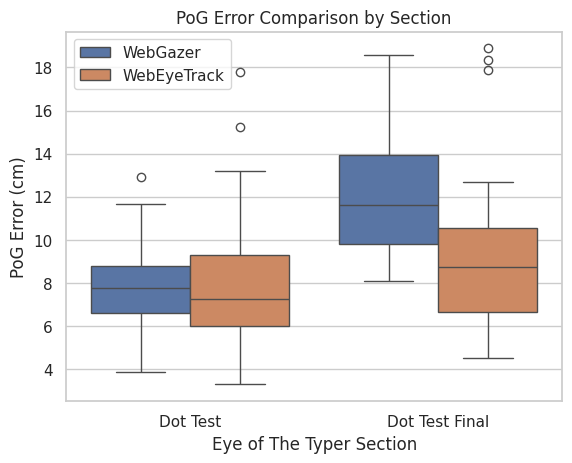

In [20]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(data=accuracy_df, x='section', y='accuracy', hue="class")
ax.set_title("PoG Error Comparison by Section")
ax.set_xlabel("Eye of The Typer Section")
ax.set_ylabel("PoG Error (cm)")

# In the legend, remove there is no need to show the text 'class' but keep the legend's information regarding the classes
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['WebGazer', 'WebEyeTrack'], loc='upper left')

# Save the plot as well
plot_path = OUTPUT_DIR / 'pog_error_comparison_by_section.png'
ax.get_figure().savefig(plot_path, bbox_inches='tight', dpi=400)
ax.get_figure().show()

In [26]:
print(demographics_df.columns)

Index(['Participant ID', 'Participant Log ID', 'Date', 'Setting',
       'Display Width (pixels)', 'Display Height (pixels)',
       'Screen Width (cm)', 'Screen Height (cm)', 'Distance From Screen (cm)',
       'Screen Recording Start Time (Unix milliseconds)',
       'Screen Recording Start Time (Wall Clock UTC)', 'Gender', 'Age',
       'Self-Reported Race', 'Self-Reported Skin Color',
       'Self-Reported Eye Color', 'Facial Hair', 'Self-Reported Vision',
       'Touch Typer', 'Self-Reported Handedness', 'Weather', 'Pointing Device',
       'Notes', 'Time of day', 'Duration'],
      dtype='object')


In [29]:
# Assign the attributes such as "Age", "Gender", "Self-Reported Race", "Self-Reported Skin Color", and "Self-Reported Vision"
columns_to_add = [
    'Age',
    'Gender',
    'Self-Reported Race',
    'Self-Reported Skin Color',
    'Self-Reported Vision'
]
for i, row in accuracy_df.iterrows():
    participant = row['participant']
    demographics_row = demographics_df[demographics_df['Participant ID'] == participant]
    
    if not demographics_row.empty:
        for col in columns_to_add:
            accuracy_df.at[i, col] = demographics_row[col].values[0]

# Ensure to cast certain values to appropriate types
accuracy_df['Age'] = pd.to_numeric(accuracy_df['Age'], errors='coerce')

accuracy_df.head(10)

,participant,section,class,accuracy,Age,Gender,Self-Reported Race,Self-Reported Skin Color,Self-Reported Vision
0,P_01,Dot Test,WebGazer,3.897109,25.0,Male,Asian,1.0,Normal
1,P_01,Dot Test Final,WebGazer,9.562728,25.0,Male,Asian,1.0,Normal
2,P_02,Dot Test,WebGazer,8.795707,22.0,Male,Asian,1.0,Normal
3,P_02,Dot Test Final,WebGazer,11.736777,22.0,Male,Asian,1.0,Normal
4,P_06,Dot Test,WebGazer,6.347425,25.0,Female,White,1.0,Normal
5,P_06,Dot Test Final,WebGazer,16.169585,25.0,Female,White,1.0,Normal
6,P_07,Dot Test,WebGazer,5.820472,27.0,Female,Asian,4.0,Glasses
7,P_07,Dot Test Final,WebGazer,12.477518,27.0,Female,Asian,4.0,Glasses
8,P_08,Dot Test,WebGazer,7.304759,23.0,Male,White,1.0,Glasses
9,P_08,Dot Test Final,WebGazer,17.157171,23.0,Male,White,1.0,Glasses


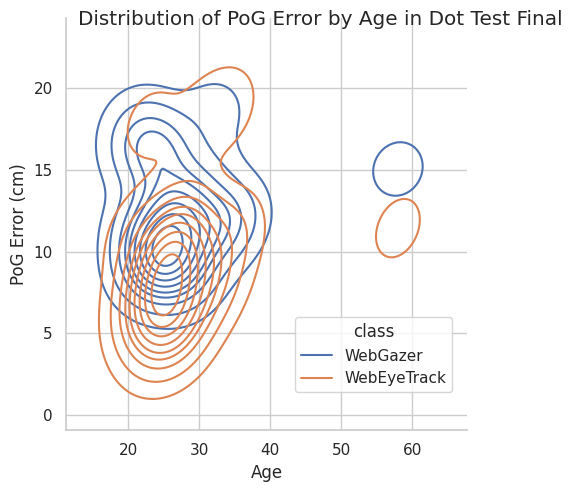

In [ ]:
# Show a distribution of performance by age
final_dot_test = accuracy_df[accuracy_df['section'] == 'Dot Test Final']
sns.set_theme(style="whitegrid")
ax = sns.displot(data=final_dot_test, x="Age", y='accuracy', hue="class", kind="kde")
sns.move_legend(obj = ax, labels=['WebGazer', 'WebEyeTrack'], loc = 'lower left', bbox_to_anchor = (0.45, 0.20), frameon = True)
ax.fig.suptitle("Distribution of PoG Error by Age in Dot Test Final")

# Change the y-axis title to "PoG Error (cm)"
ax.set_axis_labels("Age", "PoG Error (cm)")

# Save the plot
plot_path = OUTPUT_DIR / 'pog_error_distribution_by_age.png'
ax.savefig(plot_path, bbox_inches='tight', dpi=400)

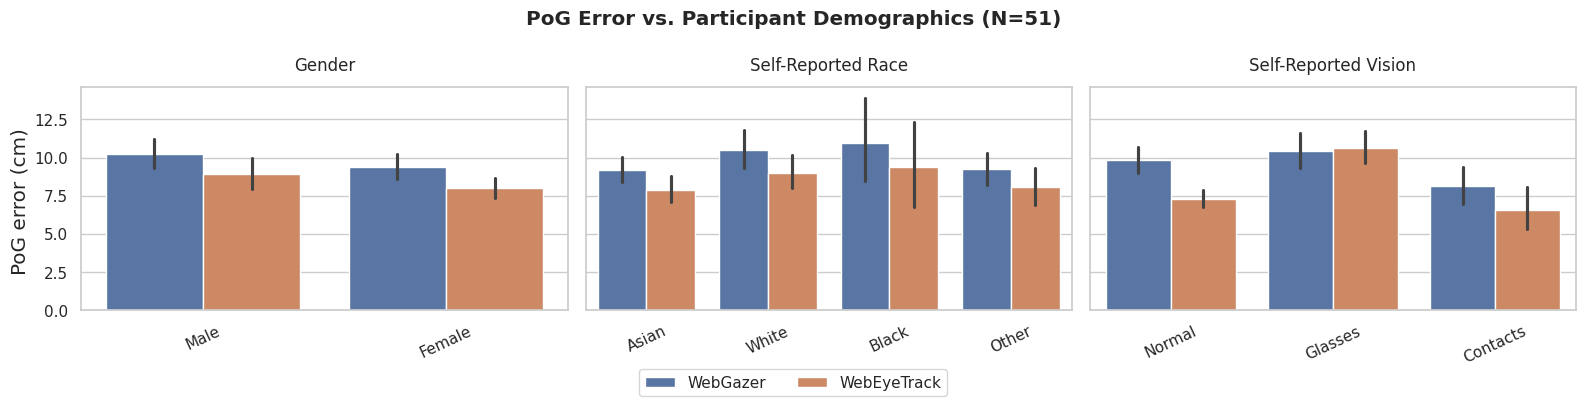

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------------
# 1)  Tell the code which column goes in which panel and in what order
# ---------------------------------------------------------------------------
demographics = {
    'Gender'               : ['Male', 'Female'],
    'Self-Reported Race'   : ['Asian', 'White', 'Black', 'Other'],
    'Self-Reported Vision' : ['Normal', 'Glasses', 'Contacts']
}

# ---------------------------------------------------------------------------
# 2)  Build a 1×3 grid of barplots
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(
        nrows=1, ncols=len(demographics),
        figsize=(16, 4),          # ← (a) wider figure – change numbers freely
        sharey=True               # common y-axis so bars are comparable
)

for ax, (col, order) in zip(axes, demographics.items()):
    sns.barplot(
        data=accuracy_df,
        x=col, y='accuracy', hue='class',
        order=order,              # stick to the categories listed above
        ax=ax
    )
    ax.set_ylabel("")
    ax.set_xlabel("")             # drop x-axis label (the title is enough)
    ax.set_title(col, pad=12)
    ax.tick_params(axis='x', rotation=25)
    ax.get_legend().remove()      # ← (b) remove *this* axis’ legend

# ---------------------------------------------------------------------------
# 3)  Figure-level polish
# ---------------------------------------------------------------------------
fig.suptitle("PoG Error vs. Participant Demographics (N=51)", weight='bold')
fig.supxlabel("")                 # no global x-label
fig.supylabel("PoG error (cm)", x=0.01)  # global y-label

# one shared legend centred above the plot (optional; delete if not wanted)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels))
fig.tight_layout()

# Save the plot
plot_path = OUTPUT_DIR / 'pog_error_vs_participant_demographics.png'
fig.savefig(plot_path, bbox_inches='tight', dpi=400)
plt.show()


In [107]:
# Load the tensorboard data to plot the embedding size comparisons
import tensorflow as tf
from tensorflow.core.util import event_pb2
# from tensorflow.python.summary.summary_iterator import summary_iterator

data = defaultdict(list)
for dir in EMBEDDING_SIZE_EXP_DIR.iterdir():
    if dir.is_dir():
        print(f"Found directory: {dir.name}")
        for file in dir.glob('events.out.tfevents.*'):
            serialized_examples = tf.data.TFRecordDataset(str(file))
            for serialized_example in serialized_examples:
                event = event_pb2.Event.FromString(serialized_example.numpy())
                for value in event.summary.value:
                    if 'train' in value.tag and 'ssim' in value.tag:
                        t = tf.make_ndarray(value.tensor)
                        # print(f"Tag: {value.tag}, Step: {event.step}, Value: {t}")
                        data['embedding_size'].append(dir.name.split('_')[1])  # Extract embedding size from directory name
                        data['step'].append(event.step)
                        data['value'].append(float(t))

# Trip any steps that are equal or larger than 20
embedding_size_df = pd.DataFrame(data)
embedding_size_df = embedding_size_df[embedding_size_df['step'] < 20]
embedding_size_df.head(10)

Found directory: mpiifacegaze_64
Found directory: mpiifacegaze_256
Found directory: mpiifacegaze_512
Found directory: mpiifacegaze_1024


2025-06-09 20:06:38.546528: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,embedding_size,step,value
0,64,0,0.710901
1,64,1,0.756857
2,64,2,0.774386
3,64,3,0.784159
4,64,4,0.790300
5,64,5,0.795067
6,64,6,0.798258
7,64,7,0.800808
8,64,8,0.802944
9,64,9,0.804844


/tmp/ipykernel_2661117/3951611150.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.get_figure().show()


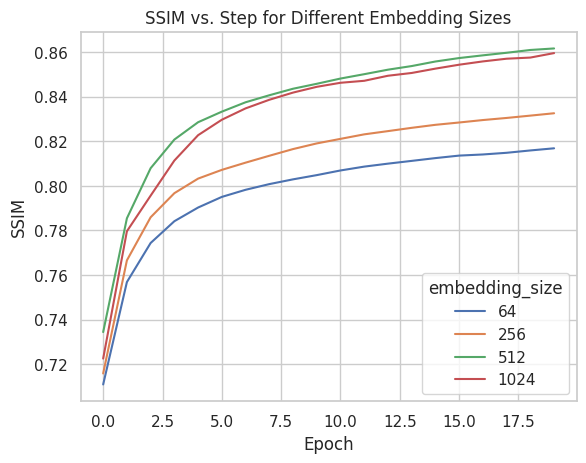

In [109]:
# Make a line plot of the embedding size vs. SSIM
sns.set_theme(style="whitegrid")
ax = sns.lineplot(data=embedding_size_df, x='step', y='value', hue='embedding_size')
ax.set_title("SSIM vs. Step for Different Embedding Sizes")
ax.set_xlabel("Epoch")
ax.set_ylabel("SSIM")
# Save the plot
plot_path = OUTPUT_DIR / 'embedding_size_vs_ssim.png'
ax.get_figure().savefig(plot_path, bbox_inches='tight', dpi=400)
ax.get_figure().show()